In [1]:
import numpy as np
from pathlib import Path
import struct#用于数据类型的转换 bytes to str
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
def Read_img_File(filepath):
    with open(filepath,'rb') as f:
        struct.unpack('>4i',f.read(16))#4i代表4位整型，int：占4字节，4*8=32bit
        data=np.fromfile(f,dtype=np.uint8)
        return data.reshape(-1,28*28)
    
def Read_label_File(filepath):
    with open(filepath,'rb') as f:
        struct.unpack('>2i',f.read(8))
        data=np.fromfile(f,dtype=np.uint8)
        return data
def loadDataSets():
    train_img_path='handwrite/train-images.idx3-ubyte'
    train_label_path='handwrite/train-labels.idx1-ubyte'
    test_img_path='handwrite/t10k-images.idx3-ubyte'
    test_label_path='handwrite/t10k-labels.idx1-ubyte'
    train_img=Read_img_File(train_img_path)
    train_label=Read_label_File(train_label_path)
    test_img=Read_img_File(test_img_path)
    test_label=Read_label_File(test_label_path)
    return train_img,train_label,test_img,test_label
train_img,train_label,test_img,test_label=loadDataSets()


In [3]:
#激活函数
def sigmoid(z):
    return 1/(1+np.exp(-z))
#激活函数导数
def d_sigmoid(z):
    s=sigmoid(z)
    return s*(1-s)
#初始化权重矩阵
def theta_init(layer_activity_num):
    theta=[]
    for i in range(len(layer_activity_num)-1):
        m=layer_activity_num[0]+layer_activity_num[-1]
        theta_temp=np.random.uniform(-np.sqrt(6/m),np.sqrt(6/m),size=(layer_activity_num[i+1],layer_activity_num[i]+1))
        theta.append(theta_temp)
    return theta

In [4]:
#正向传播
def ForwardPropagation(X,theta):
    #a=X.T #某层的激活项
    a=X
    activity=[]#记录所有层的激活项
    activity.append(a)
    for i in range(len(theta)):
        a=np.vstack([np.ones((1,a.shape[1])),a])#添加偏置单元
        Z=theta[i].dot(a)#矩阵相乘得到Z
        a=sigmoid(Z)#计算下一层激活项a
        activity.append(a)
    return activity

In [5]:
#计算代价
def cost_function(theta,Y_predict,Y,Lamaba):
    m=Y.shape[1]
    part1=-(Y*np.log(Y_predict)+(1-Y)*np.log(1-Y_predict)).sum()/m
    part2=0
    for i in range(len(theta)):
        part2+=((np.delete(theta[i],0,axis=1)**2).sum()*Lamaba)/(2*m)
    J=part1+part2
    return J

In [6]:
#反向传播,小批量梯度下降
#计算出所有的偏导数
def Backpropagation(activity,theta,Y,lamada):
    #1.计算误差项
    err_list=[]
    d_theta_list=[]
    err=activity[-1]-Y #输出层的误差
    err_list.append(err)
    #从theta最后一层向前传播
    ix=len(theta)-1
    count_i=0
    while ix>=0:
        theta_temp=np.delete(theta[ix],0,axis=1)
        #计算前一层的误差
        err=theta_temp.T.dot(err)*d_sigmoid(activity[ix])
        err_list.insert(0,err)
        #2.求各个theta的偏导
        #给每一列激活项添加偏置项
        activity_temp=np.vstack([np.ones((1,activity[ix].shape[1])),activity[ix]]).T
        #用于更新偏导的theta临时变量，加上一层偏置项0
        theta_temp=np.hstack([np.zeros((theta_temp.shape[0],1)),theta_temp])
        #取前一层误差
        err_temp=err_list[1]
        #用于所有偏导阵相加的零阵
        d_theta=np.zeros((theta[ix].shape[0],theta[ix].shape[1]))
        m=activity_temp.shape[0]
        #m：样本数
        for act_ix in range(m):   
            #某一个样本的偏导矩阵
            d_theta_temp=err_temp[:,act_ix].reshape(-1,1)*activity_temp[act_ix]
            d_theta+=d_theta_temp #每一个样本计算的偏导矩阵叠加
            d_theta=d_theta/m+theta_temp*(lamada/m)#计算该层所有的偏导
        #得到一个偏导叠加的矩阵
        d_theta_list.insert(0,d_theta)
        ix-=1
    return d_theta_list


In [7]:
#预测 x:列向量
def predict(X,theta):
    activity=ForwardPropagation(X,theta)
    Y=activity[-1]
    return np.argmax(Y,axis=0)

In [8]:
def show_img(img):
    plt.imshow(img.reshape(28,28),cmap='gray')

In [9]:
#layer=[28*28,28*28,10]
#theta1=theta_init(layer)
def model_test(theta):
    testnum=10000
    x=test_img[0:testnum].T
    y=test_label[0:testnum]
    y_p=predict(x,theta)
    counti=0
    for y_1,y_2 in zip(y,y_p):
        if(y_1!=y_2):
            counti+=1
    err_rate=counti/testnum
    right_rate=1-err_rate
    print("分类错误个数为：",counti,'分类正确数：',testnum-counti)
    print('正确率:',right_rate)

In [29]:
def train(theta):
    #测试数量
    test_num=9000
    #每一批的数量
    batch_num=10
    #输入值X
    X=train_img[:test_num,:].T
    #标签对应的向量Y
    Y_label=train_label[:test_num]
    Y_exa=np.identity(10)
    Y=Y_exa[Y_label[0]].reshape(-1,1)
    for i in range(1,Y_label.shape[0]):
        Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])
    #print(X.shape,Y.shape)#(784,20000) (10, 20000)
    #---生成Y-----
    #开始训练
    #初始化参数：
    layer=[28*28,28*28,10]
    lamada=1#正则化参数
    learn_rate=0.04#学习率
    #theta=theta_init(layer)
    cycle_num=int(test_num/batch_num)
    for turn_num in trange(cycle_num):
        #print("正在进行第%s轮"%(turn_num+1))
        X_t=X[:,turn_num*batch_num:(turn_num+1)*batch_num]
        Y_t=Y[:,turn_num*batch_num:(turn_num+1)*batch_num]
        #正向传播，得到每一层的激活项
        activity=ForwardPropagation(X_t,theta)
        #J=cost_function(theta,activity[-1],Y_t,lamada)
        #print("当前的代价：",J)
        #反向传播，得到每一层的偏导矩阵
        d_theta_list=Backpropagation(activity,theta,Y_t,lamada)
        #更新theta
        for i in range(len(theta)):
            if turn_num%(cycle_num/3)==0:
                learn_rate=learn_rate*0.5
            theta[i]=theta[i]-learn_rate*d_theta_list[i]
    print('训练完毕！')
    return theta
    #0.3  分类错误个数为： 6965 正确率: 0.3035 
    #0.04 分类错误个数为： 2632 正确率: 0.7368
    #0.01 分类错误个数为： 2577 正确率: 0.7423
    #0.003-0.009
    #0.001分类错误个数为： 3565 正确率: 0.6435
    #0.03-0.015    分类错误个数为： 2644  正确率: 0.7356
    #0.04 分类错误个数为： 2163 分类正确数： 7837 正确率: 0.7837000000000001
    #分类错误个数为： 2046 分类正确数： 7954 正确率: 0.7954
    #分类错误个数为： 2085 分类正确数： 7915 正确率: 0.7915

In [25]:
def train1():
    #测试数量
    test_num=3000
    #每一批的数量
    batch_num=10
    #输入值X
    X=train_img[:test_num,:].T
    #标签对应的向量Y
    Y_label=train_label[:test_num]
    Y_exa=np.identity(10)
    Y=Y_exa[Y_label[0]].reshape(-1,1)
    for i in range(1,Y_label.shape[0]):
        Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])
    #print(X.shape,Y.shape)#(784,20000) (10, 20000)
    #---生成Y-----
    #开始训练
    #初始化参数：
    layer=[28*28,28*28,10]
    lamada=1#正则化参数
    learn_rate=0.04#学习率
    theta=theta_init(layer)
    #学习轮数
    turn_total=3
    cycle_num=turn_total*int(test_num/batch_num)
    print("训练轮数：",turn_total)
    for turn_num in trange(cycle_num):
        #print("正在进行第%s轮"%(turn_num+1))
        turn=turn_num%test_num
        X_t=X[:,turn*batch_num:(turn+1)*batch_num]
        Y_t=Y[:,turn*batch_num:(turn+1)*batch_num]
        #正向传播，得到每一层的激活项
        activity=ForwardPropagation(X_t,theta)
        #J=cost_function(theta,activity[-1],Y_t,lamada)
        #print("当前的代价：",J)
        #反向传播，得到每一层的偏导矩阵
        d_theta_list=Backpropagation(activity,theta,Y_t,lamada)
        #更新theta
        for i in range(len(theta)):
            if turn_num%(cycle_num/3)==0:
                learn_rate=learn_rate*0.5
            theta[i]=theta[i]-learn_rate*d_theta_list[i]
    print('训练完毕！')
    return theta
    #分类错误个数为： 3048 分类正确数： 6952 正确率: 0.6952

    #

In [27]:
theta=train()

  0%|                                                  | 0/900 [00:00<?, ?it/s]G:\WorkProgram\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
100%|████████████████████████████████████████| 900/900 [02:09<00:00,  7.10it/s]


训练完毕！


In [92]:
model_test(theta)

分类错误个数为： 2085 分类正确数： 7915
正确率: 0.7915


In [104]:
import pickle
with open('bpnet-model.txt','wb') as f:
    pickle.dump(theta,f)

    

In [111]:
with open('bpnet-model.txt','rb') as f:
    print(pickle.load(f))

[array([[ 1.91287149e-02, -1.00207838e-02, -1.48426785e-03, ...,
        -1.10369128e-02,  1.06567585e-02, -2.87644993e-04],
       [ 8.37091927e-02, -7.75219508e-03,  1.26451267e-02, ...,
        -5.25897570e-03,  9.01608021e-03,  7.46503121e-03],
       [ 1.84484443e-02, -5.00909106e-03, -3.45491371e-03, ...,
         6.24697432e-03, -4.68110481e-03,  1.13486784e-02],
       ...,
       [ 2.92631834e-02, -6.63872922e-03,  2.66266608e-04, ...,
        -2.58487560e-03,  1.42233964e-02, -9.49787915e-03],
       [ 3.80019381e-02,  1.45654355e-02,  4.14948971e-03, ...,
         3.60423772e-05,  4.13600197e-04,  9.97979903e-05],
       [ 1.22037222e-03,  5.43231851e-04,  5.84286590e-03, ...,
         3.50276719e-03,  1.76444902e-04,  5.06412413e-04]]), array([[ 4.18981420e-02,  8.97614960e-03, -1.61044649e-02, ...,
         6.72716551e-03, -1.61234093e-02, -2.13491335e-02],
       [ 6.05297127e-02, -2.74809495e-03,  3.07214259e-02, ...,
         1.10074717e-02, -3.40526902e-03, -7.64575860

label: 1
预测值 [8]


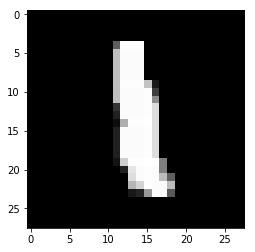

In [91]:
import random
rd=random.randint(0,1000)
x=test_img[rd].reshape(-1,1)
y=test_label[rd]
y_p=predict(x,theta)
show_img(x)
print('label:',y)
print('预测值',y_p)